# Example notebook for a single endpoint

This notebook is part of the supporting information to the manuscript entitled "Conformal Prediction and 
Exchangeability in Toxicological In Vitro Datasets (title tbd)". The notebook was developed by Andrea Morger in the 
In Silico Toxicology and Structural Biology Group of Prof. Dr. Andrea Volkamer at the Charité Universitätsmedizin 
Berlin, in collaboration with Fredrik Svensson, Ulf Norinder and Ola Spjuth. It was last updated in September 2020.

## Content

This notebooks demonstrates the main workflow to obtain the results for the manuscript on "conformal prediction and exchangeability in in vitro toxicological datasets" (todo: exchange with title of the manuscript) for an example endpoint.
It can be used to train aggregated conformal predictors on the Tox21 endpoints. The predictions of Tox21 score can be compared in different experiments with and without updated calibration sets as well as with updating the complete training set. The notebook may be adapted to use the code for different datasets if a different endpoint is selected in `input cell 6.`

For a general introduction on conformal prediction, exchangeability and calibration plots we refer to the manuscript.

The notebook consists of three main parts.

1. Preparation
    - Used Python libraries are loaded
    - Paths and parameters are defined
2. Conformal prediction experiments
    - Load data
    - Prepare and perform experiments with different calibration sets
    - Prepare and perform experiments with an updated training set
3. Evaluate conformal predictions
    - Calibration plots
    - Calculate and plot rmsds
    - Plot nonconformity scores

### Table of contents
1. [Preparation](#preparation) <br>
    1.1. [Import libraries and modules](#import-libraries-and-modules)<br>
    1.2. [Define paths and parameters](#define-paths-parameters)<br>
2. [Conformal prediction experiments](#cp-experiments)<br>
    2.1. [Load datasets](#load-data)<br>
    2.2. [Prepare and perform experiments with different calibration sets](#exp-different-cal-sets)<br>
    2.3. [Prepare and perform experiments with an updated training set](#exp-updated-train-set)<br>
3. [Evaluate conformal predictions](#evaluate-cp)<br>
    3.1. [Calibration plots](#cal-plots)<br>
    3.2. [rmsd's](#rmsds)<br>
    3.3. [nonconformity scores](#nc-scores)<br>

## 1. Preparation
### 1.1. Import libraries and modules

In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
from sklearn.svm import SVC
from nonconformist.nc import NcFactory, MarginErrFunc
import matplotlib.pyplot as plt

In [3]:
from cptox21 import (
    define_path, load_signatures_files, StratifiedRatioSampler,CrossValidationSampler,
    KnownIndicesSampler, InductiveConformalPredictor,
    AggregatedConformalPredictor, CPTox21AggregatedConformalPredictor, 
    CPTox21CrossValidator, CPTox21TrainUpdateCrossValidator, 
    calculate_rmsd_from_df, calculate_rmsd_pos_from_df
)

In [4]:
import warnings
warnings.simplefilter("ignore")

### 1.2. Define paths and parameters

In [5]:
data_signatures_path = "../data/data_signatures/"
data_statistics_path = "../data/data_statistics/"

In [6]:
endpoint = "NR_ER"

In [7]:
# Number of loops used in ACP
n_folds_acp = 4  # 10

## 2. Conformal prediction experiments
### 2.1. Load datasets

In [10]:
datasets = ["train", "test", "score"]  # Tox21 datasets
train_path = define_path(endpoint=endpoint, data=datasets[0], signatures_path=data_signatures_path)
test_path = define_path(endpoint=endpoint, data=datasets[1], signatures_path=data_signatures_path)
score_path = define_path(endpoint=endpoint, data=datasets[2], signatures_path=data_signatures_path)

X_train, y_train, X_test, y_test, X_score, y_score = load_signatures_files(train_path, test_path, score_path)

# Uncomment below code for final run (shortens calculation time for test runs)
X_train = X_train[:500]
y_train = y_train[:500]

#### Compare size of datasets
To interpret and assess the results, it might be useful to know, how many data points we actually have per dataset, and how balanced they are.

In [11]:
datasets_size_dict = {}
datasets_size_dict["name"] = datasets
datasets_size_dict["actives"] = []
datasets_size_dict["inactives"] = []

for dataset, labels in zip(datasets, [y_train, y_test, y_score]):
    num_actives = np.sum(labels)
    num_inactives = len(labels) - num_actives
    datasets_size_dict["actives"].append(num_actives)
    datasets_size_dict["inactives"].append(num_inactives)
        

pd.DataFrame.from_dict(datasets_size_dict)

,name,actives,inactives
0,train,132.0,368.0
1,test,27.0,231.0
2,score,49.0,441.0


### 2.2. Prepare and perform experiments with different calibration sets
#### Build ICP classifier

In [8]:
clf = SVC(kernel='rbf', C=50, gamma=0.002, probability=True)
error_function = MarginErrFunc()
normaliser_model = None
nc = NcFactory.create_nc(clf, err_func=error_function)
icp = InductiveConformalPredictor(nc_function=nc, condition=(lambda instance: instance[1]))
# Mondrian as (default) condition)

#### Build ACP for main framework (excluding for train_update)

In [9]:
acp = CPTox21AggregatedConformalPredictor(
    predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp), aggregation_func=np.median
)

#### Load data

#### Define crossvalidator, which does all acp experiments except for train_update

In [12]:
cross_validator = CPTox21CrossValidator(
    acp, cv_splitter=CrossValidationSampler(), score_splitter=StratifiedRatioSampler(test_ratio=0.5)
)

#### Crossvalidate

In [13]:
cross_validation_dfs = cross_validator.cross_validate(
    steps=10,
    endpoint=endpoint,
    X_train=X_train,
    y_train=y_train,
    X_update=X_test,
    y_update=y_test,
    X_score=X_score,
    y_score=y_score,
)

len score 245 245
len score 245 245
len score 245 245
len score 245 245
len score 245 245


## 2.3. Prepare and perform experiments with an updated training set

#### Get splits from crossvalidator, so that exactly the same splits can be used for train_update

In [14]:
train_index, test_index = cross_validator.train_indices, cross_validator.test_indices

known_indices_sampler = KnownIndicesSampler(known_train=train_index, known_test=test_index)

#### Define ACP for train_update
Difference to CPTox21AggregatedConformalPredictor: As we do not further update the calibration set for this experiment, here, we can use a 'typical' ACP.

In [15]:
train_update_acp = AggregatedConformalPredictor(
    predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp), aggregation_func=np.median
)

#### Define train_update crossvalidator using same splits as before and crossvalidate

In [16]:
train_update_cross_validator = CPTox21TrainUpdateCrossValidator(
    train_update_acp, cv_splitter=known_indices_sampler
)

train_update_cross_validation_dfs = train_update_cross_validator.cross_validate(
    steps=10, 
    endpoint=endpoint,
    X_train=X_train,
    y_train=y_train,
    X_update=X_test,
    y_update=y_test,
    X_score=X_score,
    y_score=y_score,
)

[df[["validity", "efficiency", "accuracy", "significance_level"]].head() for df in train_update_cross_validation_dfs]

[   validity  efficiency  accuracy  significance_level
 0      1.00        0.00     0.000                 0.0
 1      0.93        0.37     0.811                 0.1
 2      0.91        0.57     0.842                 0.2
 3      0.77        0.85     0.729                 0.3
 4      0.65        0.88     0.739                 0.4,
    validity  efficiency  accuracy  significance_level
 0     1.000       0.000     0.000                 0.0
 1     0.939       0.243     0.748                 0.1
 2     0.841       0.531     0.700                 0.2
 3     0.731       0.829     0.675                 0.3
 4     0.573       0.816     0.702                 0.4]

## 3. Evaluate conformal predictions

### 3.1. Calibration plots
In a calibration plot, the observed error rate for a batch of predictions is plotted against the expected error rate (diagonal line). To provide some more information, we also plot the efficiency, defined as the ratio of single class predictions. The firm lines in the plot are the mean values of a five-fold cross-validation, the shaded areas represent the standard deviation.

Calibration plots are useful for investigating the exchangeability between the datasets, and also to analyse the improvement strategies (see below).

In [17]:
plots = {}

##### Cross-validation
As proof-of-concept, let's look at the calibration plot of the cross-validation. Given the random stratified splitting and sufficient data, the error rate should follow the diagonal line.

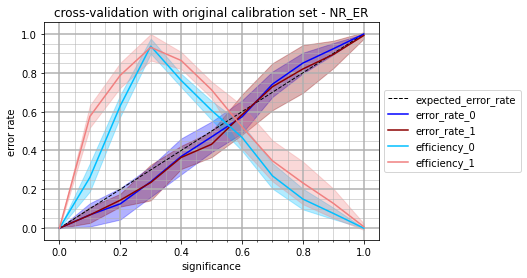

In [18]:
plots["cv"] = cross_validator.calibration_plot( 
    averaged_evaluation_df=cross_validator.averaged_evaluation_df_cv,
    endpoint=endpoint,
    title_name="cross-validation with original calibration set"
)

##### Predict score and test set using the aggregated conformal predictor with the 'original' calibration set
If the training set and the predicted data are drawn from the same distribution, and if they are available in sufficient amount, the error rates should follow the diagonal line. Any deviations suggest inexchangeability (or too few data). 

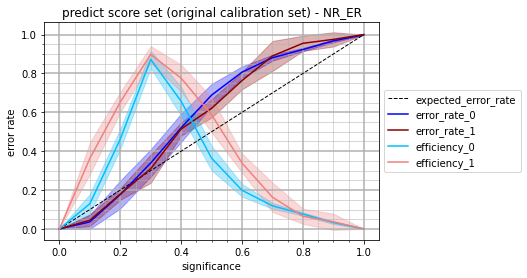

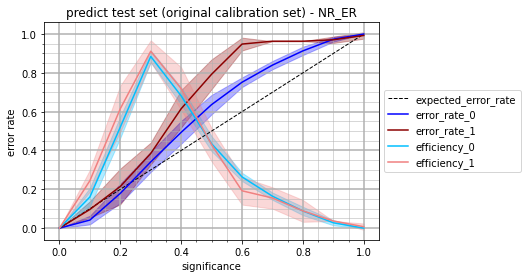

In [19]:
plots["pred_score"] = cross_validator.calibration_plot(
    averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_score,
    endpoint=endpoint, 
    title_name="predict score set (original calibration set)"
)

plots["pred_test"] = cross_validator.calibration_plot(
    averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_test,
    endpoint=endpoint, 
    title_name="predict test set (original calibration set)"
)

##### Update (increase) the training set with more recent data
Probably the most intuitive way to improve the validity of the predictions will be to update the training set with more recent data. If "old and new" data are available, they can be combined to train a more up-to-date model. The following plots show the cross-validation of this model as well as the prediction of score data. 

For the prediction of the score data, we, usually (for most endpoints), do not see a big difference to the above calibration plot, since the number of recent compounds is almost negligible compared to the number of original training compounds. On the other hand, the more recent data would not be enough for training a model on them alone.

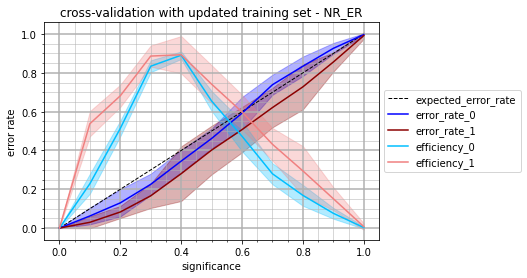

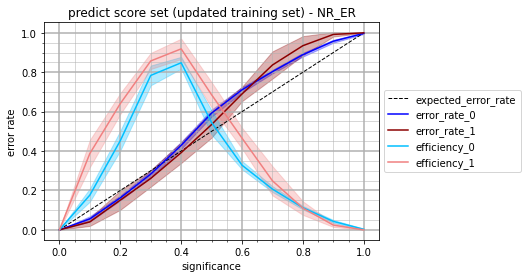

In [20]:
plots["train_update_cv"] = train_update_cross_validator.calibration_plot(
    averaged_evaluation_df=train_update_cross_validator.averaged_evaluation_df_cv,
    endpoint=endpoint, 
    title_name="cross-validation with updated training set"
)

plots["train_update_pred_score"] = train_update_cross_validator.calibration_plot(
    averaged_evaluation_df=train_update_cross_validator.averaged_evaluation_df_pred_score,
    endpoint=endpoint, 
    title_name="predict score set (updated training set)"
)

##### Update (exchange) the calibration set with a more recent dataset
If exchangeability between the datasets cannot be assumed, a proposed strategy to improve the applicability of the model, is to update the calibration set with more recent data.
Based on the chronogical release of the Tox21 datasets, we assume that Tox21test is more similar to Tox21 score than Tox21 train. Thus Tox21test is used to update the calibration set.

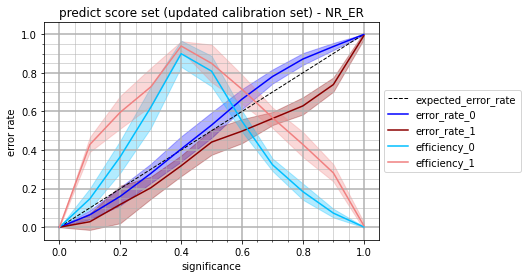

In [21]:
plots["cal_update"] = cross_validator.calibration_plot(
    averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_cal_update,
    endpoint=endpoint, 
    title_name="predict score set (updated calibration set)"
)

##### Update (exchange) the calibration set with part of the current prediction set
With the above updating experiment, we made an assumption about the similarity of the datasets. This assumption was not true for all datasets. Thus, a more suitable experiment would be to update the calibration set with one part (50%) of the score set and to predict the other part of the score set. This gives us the certainty that the calibration and the prediction set are drawn from the same distribution. Note, that this might be more suitable as a proof of concept, on the other hand it does not represent a real-life scenario. Furthermore, we might see a larger standard deviation in the error rate, as we predict fewer data points.

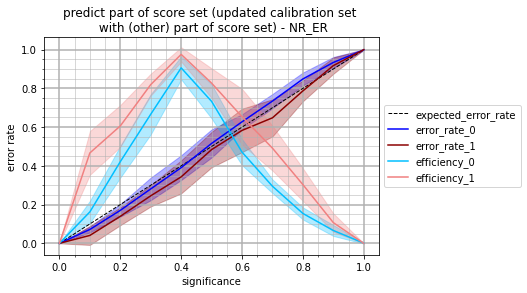

In [22]:
plots["cal_update2"] = cross_validator.calibration_plot(
    averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_cal_update2,
    endpoint=endpoint, 
    title_name="predict part of score set (updated calibration set \n with (other) part of score set)"
)

### 3.2. rmsd's
To have a value to compare the calibration plots (validity) over all experiments, we calculate the rmsd of the observed error rate to the expected error rate (for 10 significance levels). If we accept overconservative validity, we can also calculate rmsd_pos (todo: change term/name?), only considering the deviation where the observed error rate is higher than the expected error rate.

#### Collect data (evaluation dfs) from the cross-validators

In [23]:
evaluation_dfs = {}
evaluation_dfs["cv_original"] = cross_validator.averaged_evaluation_df_cv
evaluation_dfs["pred_score_original"] = cross_validator.averaged_evaluation_df_pred_score
evaluation_dfs["pred_test_original"] = cross_validator.averaged_evaluation_df_pred_test
evaluation_dfs["train_update"] = train_update_cross_validator.averaged_evaluation_df_pred_score
evaluation_dfs["pred_score_calupdate"] = cross_validator.averaged_evaluation_df_pred_cal_update
evaluation_dfs["pred_score_calupdate2"] = cross_validator.averaged_evaluation_df_pred_cal_update2

#### Calculate rmsd's

In [24]:
rmsds = {}
rmsds_pos = {}
for k, v in evaluation_dfs.items():

    rmsd = calculate_rmsd_from_df(v)
    rmsds[k] = rmsd
    
    rmsd_pos = calculate_rmsd_pos_from_df(v)
    rmsds_pos[k] = rmsd_pos
rmsds

{'cv_original': 0.039,
 'pred_score_original': 0.116,
 'pred_test_original': 0.101,
 'train_update': 0.066,
 'pred_score_calupdate': 0.034,
 'pred_score_calupdate2': 0.025}

#### Scatter plot
To visualise the rmsds over all strategies, a scatter plot can be used

In [25]:
def plot_rmsds(rmsds, strategies, endpoint=endpoint):
    plt.clf()
    fig = plt.figure(figsize=(10,5))
    
    plt.scatter(strategies, [rmsds[s] for s in strategies], marker='_', s=500)
    plt.xticks(rotation='vertical')
    plt.title(f"rmsds for different CP set-ups - {endpoint} endpoint")    

In [26]:
strategies = ["cv_original", "pred_score_original", "pred_test_original", "train_update", "pred_score_calupdate",
             "pred_score_calupdate2"]

<Figure size 432x288 with 0 Axes>

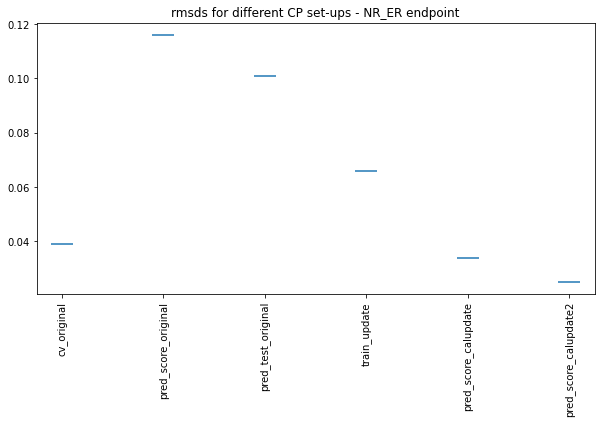

In [27]:
plot_rmsds(rmsds, strategies)

### 3.3. Plot nonconformity scores
For some endpoints, the above updating strategy (with more recent data/Tox21test) worked very nicely, for others it didn't. Plotting the nonconformity scores for the different datasets (this is done BEFORE calibration) might help to investigate the similarity of the datasets. Are Tox21train and Tox21score really very far from each other while the nonconformity scores Tox21test lie somewhere in between?

(<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/cptox21_SI/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <matplotlib.legend.Legend at 0x7f8b30213250>)

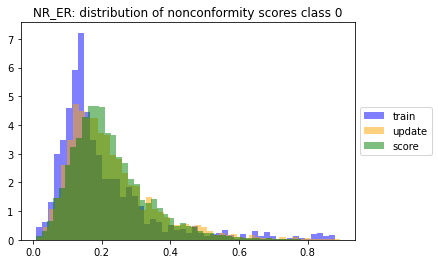

In [28]:
cross_validator.plot_nonconformity_scores(cl=0, endpoint=endpoint)

(<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/cptox21_SI/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <matplotlib.legend.Legend at 0x7f8b2afc22b0>)

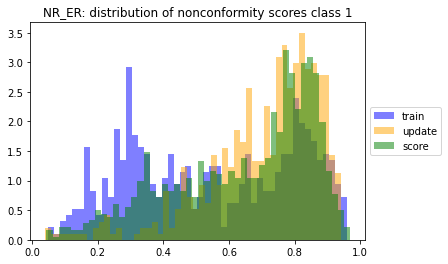

In [29]:
cross_validator.plot_nonconformity_scores(cl=1, endpoint=endpoint)